## Calibrate AD99 parameters to check deficiency cannot be corrected
### Load data


In [1]:
from dask_jobqueue import SLURMCluster
NCORES = 8
NPROCESS = 8
NCORESPERPROCESS = NCORES//NPROCESS
constraints = ['-C \"CLASS:SH4_CBASE|CLASS:SH4_CPERF\"'] # SH4 nodes are the fastest, and mixing node gens seems to cause ib0 issues.
cluster = SLURMCluster(queue='serc',memory='96GiB',cores=NCORES,processes=NPROCESS,walltime='06:00:00',job_extra_directives=constraints,log_directory='/scratch/users/robcking/dask_worker_logs')
cluster.scale(jobs=30) # roughly but tune to scheduler 
cluster



Dashboard: http://10.20.9.14:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.20.9.14:33100,Workers: 0
Dashboard: http://10.20.9.14:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
from dask.distributed import Client

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.20.9.14:8787/status,
Dashboard: http://10.20.9.14:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.20.9.14:33100,Workers: 0
Dashboard: http://10.20.9.14:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update ({
'font.family':"sans-serif",
'font.style': 'normal',
'font.size':18,
'figure.figsize':(8,6),
})
PLT_ORANGE = plt.cm.Oranges(0.7)
PLT_GREEN = plt.cm.Greens(0.7)

In [4]:
import os 
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
from ad99py.masks import mask_dataset
BASIN = None 
FIGDIR = 'figures'
DATADIR = 'data'
exp = 'AD99 c0=u0 (include unbroken)'
use_intrinsic_c='always'
expcode = 'always_include_unbroken_1year'
exclude_unbroken=True


ERA5_DATASET = f"{DATADIR}/era5_{expcode}.nc"
GCM_DATASET = f"{DATADIR}/mima_gwf_{expcode}.nc"


# ds_era5 = xr.open_dataset(ERA5_DATASET)
ds_gcm = xr.open_dataset(GCM_DATASET,chunks={'time':1})
ds_era5 = xr.open_dataset(ERA5_DATASET,chunks={'time':1})


ds_era5 = mask_dataset(ds_era5,dir=DATADIR,basins=BASIN)
ds_gcm = mask_dataset(ds_gcm,dir=DATADIR,basins=BASIN)

ds_era5 = ds_era5.transpose('time','points','level')
ds_gcm = ds_gcm.transpose('time','points','level')

In [5]:
from ad99py.loon import loon_data

LOON_DATA = loon_data(basins=BASIN,path=f"{DATADIR}/loon")


In [6]:
import dask.array as da
lat_gcm = da.broadcast_to(ds_gcm.latitude.data[None,:].data,ds_gcm.u.shape[:-1])
lat_era5 = da.broadcast_to(ds_era5.latitude.data[None,:].data,ds_era5.u.shape[:-1])
lat_gcm,lat_era5

(dask.array<broadcast_to, shape=(1440, 2504), dtype=float32, chunksize=(1440, 2504), chunktype=numpy.ndarray>,
 dask.array<broadcast_to, shape=(1464, 2504), dtype=float64, chunksize=(1464, 2504), chunktype=numpy.ndarray>)

In [7]:
def filter_scale(fluxes):
    fluxes = np.abs(fluxes)
    fluxes = fluxes[fluxes > 1e-7]
    return fluxes*1000

In [8]:
LVL = 50#hPa
i_lvl = np.argmin(np.abs(ds_gcm.level.data-LVL))

In [9]:
import scipy.stats as sps
def moments(fluxes):
    mean = np.mean(fluxes)
    std = np.std(fluxes)
    skew = sps.skew(fluxes)
    kurt = sps.kurtosis(fluxes,fisher=False)
    return mean, std, skew,kurt

def moments_over_fluxes(fluxes):
    means = [0]*len(fluxes)
    stds = [0]*len(fluxes)
    skews = [0]*len(fluxes)
    kurtoses = [0]*len(fluxes)
    for i,f in enumerate(fluxes):
        means[i], stds[i], skews[i],kurtoses[i] = moments(f)
    return means, stds, skews,kurtoses

def moments_over_log_fluxes(fluxes):
    means = [0]*len(fluxes)
    stds = [0]*len(fluxes)
    skews = [0]*len(fluxes)
    kurtoses = [0]*len(fluxes)
    for i,f in enumerate(fluxes):
        log_f = np.log10(f)
        means[i], stds[i], skews[i],kurtoses[i] = moments(log_f)
    return means, stds, skews, kurtoses  

In [10]:
loon_mean, loon_std, loon_skew, loon_kurt= np.mean(LOON_DATA['u_flux_ptv']), np.std(LOON_DATA['u_flux_ptv']), sps.skew(LOON_DATA['u_flux_ptv']), sps.kurtosis(LOON_DATA['u_flux_ptv'])
loon_log_mean, loon_log_std, loon_log_skew, loon_log_kurt = np.mean(np.log10(LOON_DATA['u_flux_ptv'])), np.std(np.log10(LOON_DATA['u_flux_ptv'])), sps.skew(np.log10(LOON_DATA['u_flux_ptv'])), sps.kurtosis(np.log10(LOON_DATA['u_flux_ptv']))

### $B_t$ / $F_{S0}$ - intermittency factor
This parameter sets $\epsilon$; the intermittency rate of GWs. As discussed in the manuscript this parameter can only shift the entire distribution by a multiplicative factor. In log-space this correpsonds to an additive shift. Thus we can always correct the mean (first moment of the distribution) BUT NOT the variance or the skew!

In [11]:
exclude_unbroken=False

In [33]:
import h5py
def write_h5(path,samples,index,index_name):
    if len(index) != len(samples):
        raise ValueError("Index is inconsistent with length of data")
    with h5py.File(path,'w') as f:
        f[index_name] = index
        samples_group = f.create_group("samples")
        for i,sample in enumerate(samples):
            samples_group[str(i)] = sample

def h5_to_samples(path,index_name):
    samples = []
    with h5py.File(path) as f:
        index = f[index_name][:]
        index_length = index.shape[0]
        for i in range(index_length):
            samples.append(f[f"samples/{str(i)}"][:])
        return index,samples

    

In [34]:
from ad99py.ad99dask import AlexanderDunkerton1999Dask
from joblib import load,dump
from tqdm.notebook import tqdm


if os.path.exists(os.path.join(DATADIR,f'{expcode}_gcm_Fs0.h5')) and os.path.exists(os.path.join(DATADIR,f'{expcode}_era5_Fs0.h5')):
    # samples_Fs0_gcm = load(os.path.join(DATADIR,f'{expcode}_gcm_Fs0.pkl'))
    # samples_Fs0_era5 = load(os.path.join(DATADIR,f'{expcode}_era5_Fs0.pkl'))
    Fs0_range,samples_Fs0_gcm = h5_to_samples(os.path.join(DATADIR,f'{expcode}_gcm_Fs0.h5'),"Fs0")
    Fs0_range,samples_Fs0_era5 = h5_to_samples(os.path.join(DATADIR,f'{expcode}_era5_Fs0.h5'),"Fs0")
else:
    Fs0_range = np.logspace(-1,1,10,base=10.0)*1e-3
    samples_Fs0_era5 = []
    samples_Fs0_gcm = []
    for i,Fs0 in tqdm(enumerate(Fs0_range),total=len(Fs0_range),desc='Fs0'):
        ad99 = AlexanderDunkerton1999Dask(Fs0=Fs0,cw=35,exclude_unbroken=exclude_unbroken,use_intrinsic_c=use_intrinsic_c,dc=0.4) # this is following the MiMA spec

        _,ptv_flux = ad99.momentum_flux_neg_ptv(ds_gcm.u.data,ds_gcm.Ns.data,ds_gcm.z.data,ds_gcm.rho.data,lat_gcm)
        samples_Fs0_gcm.append(filter_scale(ptv_flux[...,i_lvl]).compute())
        _,ptv_flux = ad99.momentum_flux_neg_ptv(ds_era5.u.data,ds_era5.Ns.data,ds_era5.z.data,ds_era5.rho.data,lat_era5)
        samples_Fs0_era5.append(filter_scale(ptv_flux[...,i_lvl]).compute())
    write_h5(os.path.join(DATADIR,f'{expcode}_gcm_Fs0.h5'),samples_Fs0_gcm,Fs0_range,"Fs0")
    write_h5(os.path.join(DATADIR,f'{expcode}_era5_Fs0.h5'),samples_Fs0_era5,Fs0_range,"Fs0")
    # dump(samples_Fs0_gcm,os.path.join(DATADIR,f'{expcode}_gcm_Fs0.pkl'))
    # dump(samples_Fs0_era5,os.path.join(DATADIR,f'{expcode}_era5_Fs0.pkl'))

In [36]:
Fs0_range = Fs0_range[::2]
samples_Fs0_gcm = samples_Fs0_gcm[::2]

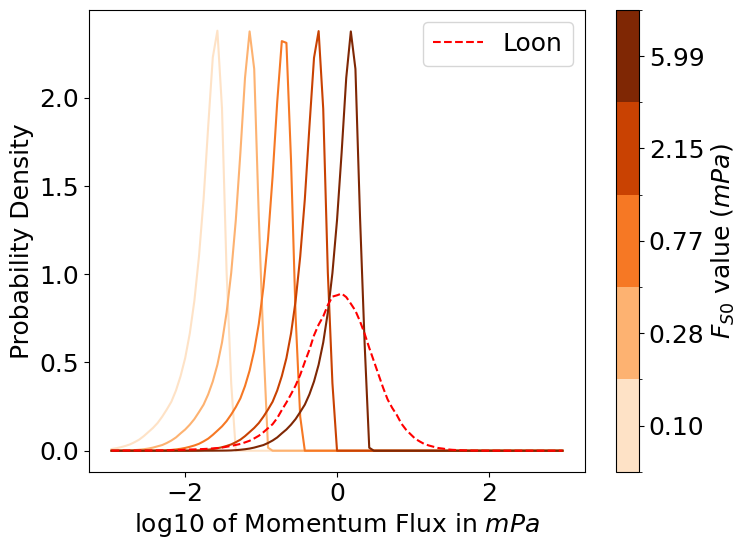

In [37]:
import matplotlib as mpl 
plt.figure(figsize=(8,6))
logbins_edge = np.linspace(-3,3,100)
logbins_centers = (logbins_edge[:-1] + logbins_edge[1:]) / 2

bounds = np.arange(len(Fs0_range)+1) - 0.5   # centers on integers

cmap_base = plt.cm.Oranges
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "oranges_cut", cmap_base(np.linspace(0.15, 1.0, 256))
)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
for i,s in enumerate(samples_Fs0_gcm):
    hist, _ = np.histogram(np.log10(s),bins=logbins_edge,density=True)
    plt.plot(logbins_centers, hist, c=cmap(norm(i)))
log_loon_hist, _ = np.histogram(np.log10(LOON_DATA['u_flux_ptv']),bins=logbins_edge,density=True)
plt.plot(logbins_centers, log_loon_hist, label='Loon', color='red',ls='--')
plt.xlabel('log10 of Momentum Flux in $\\mathit{mPa}$')
plt.ylabel('Probability Density')
plt.legend()

# Colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ticks=range(len(Fs0_range)),ax=plt.gca())
cbar.ax.set_yticklabels([f"{1000*val:.2f}" for val in Fs0_range])  # label with cw values
cbar.set_label("$F_{S0}$ value ($\\mathit{mPa}$)")
plt.savefig(f'{FIGDIR}/Fs0_{expcode}.png',dpi=300)

In [ ]:
plt.figure(figsize=(8,6))
logbins_edge = np.linspace(-3,3,100)
logbins_centers = (logbins_edge[:-1] + logbins_edge[1:]) / 2

for i,s in enumerate(samples_Fs0_era5):
    hist, _ = np.histogram(np.log10(s),bins=logbins_edge,density=True)
    plt.plot(logbins_centers, hist, c=norm())
log_loon_hist, _ = np.histogram(np.log10(LOON_DATA['u_flux_ptv']),bins=logbins_edge,density=True)
plt.plot(logbins_centers, log_loon_hist, label='Loon', color='red',ls='--')
plt.xlabel('log10(GW momentum fluxes) ($\log \\mathit{mPa}$)')
plt.ylabel('Probability Density')
plt.title("ERA5")
plt.legend()

In [ ]:
for s in samples_Fs0_gcm:
    plt.hist(s,bins=np.linspace(0,10,100),density=True,alpha=0.5)
plt.xlabel('log10(GW momentum fluxes) (log mPa)')
plt.ylabel('Density')


In [19]:
mean_true_Fs0, std_true_Fs0, skew_true_Fs0, kurt_true_Fs0 = moments_over_fluxes(samples_Fs0_gcm)
mean_log_Fs0, std_log_Fs0, skew_log_Fs0, kurt_log_Fs0 = moments_over_log_fluxes(samples_Fs0_gcm)

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,8))

ax1.plot(Fs0_range*1000,mean_true_Fs0,label='AD99')
ax1.set_xlabel('$F_{S0}$ (mPa)')
ax1.axhline(loon_mean,color='red',linestyle='--',label='Loon')
ax2.plot(Fs0_range*1000,std_true_Fs0,label='AD99')
ax2.set_xlabel('$F_{S0}$ (mPa)')
ax2.axhline(loon_std,color='red',linestyle='--',label='Loon')
ax3.plot(Fs0_range*1000,skew_true_Fs0,label='AD99')
ax3.set_xlabel('$F_{S0}$ (mPa)')
ax3.axhline(loon_skew,color='red',linestyle='--',label='Loon')

# ax1.legend()
ax1.legend()
ax2.legend()
ax3.legend()



In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(17,8))
fig.tight_layout(pad=3)
predicted_skew= -3*np.array(std_true_Fs0)/np.array(mean_true_Fs0)
ax1.plot(Fs0_range*1000,mean_log_Fs0,label='AD99',c=PLT_ORANGE)
ax1.axhline(loon_log_mean,color='red',linestyle='--',label='Loon')
ax1.set_xlabel('$F_{S0}$ ($\\mathit{mPa}$)')
ax1.set_ylabel("Mean")
ax1.set_xscale('log')
ax1.set_title("Log PDF mean")

ax1.set_ylim(-2,0.5)
ax2.plot(Fs0_range*1000,std_log_Fs0,label='AD99',c=PLT_ORANGE)
ax2.axhline(loon_log_std,color='red',linestyle='--',label='Loon')
ax2.set_xlabel('$F_{S0}$ ($\\mathit{mPa}$)')
ax2.set_ylabel("Standard Deviation")
ax2.set_ylim(0,1)
ax2.set_xscale('log')
ax2.set_title("Log PDF std")
ax3.plot(Fs0_range*1000,skew_log_Fs0,label='AD99',c=PLT_ORANGE)
ax3.axhline(loon_log_skew,color='red',linestyle='--',label='Loon')
ax3.set_xlabel('$F_{S0}$ ($\\mathit{mPa}$)')
ax3.set_ylabel("Skew")
ax3.set_ylim(-3,0)
ax3.set_xscale('log')
ax3.set_title("Log PDF skew")
plt.savefig(f'../../figures/{expcode}_Fs0_moments.png',dpi=300)
# ax1.legend()

## Phase speed distribution width ($c_w$)

In [39]:
expcode = 'always_include_unbroken_1year'

In [43]:
from tqdm.notebook import tqdm
from ad99py.ad99dask import AlexanderDunkerton1999Dask


if os.path.exists(os.path.join(DATADIR,f'{expcode}_gcm_cw.h5')) and os.path.exists(os.path.join(DATADIR,f'{expcode}_era5_cw.h5')):
    cw,samples_cw_gcm = h5_to_samples(os.path.join(DATADIR,f'{expcode}_gcm_cw.h5'),"cw")
    cw,samples_cw_era5 = h5_to_samples(os.path.join(DATADIR,f'{expcode}_era5_cw.h5'),"cw")
else:
    cw = np.arange(5,80,5) 
    samples_cw_gcm = []
    samples_cw_era5 = []
    for i,cwi in tqdm(enumerate(cw),total=len(cw),desc='$c_w$'):
        source = make_source_spectrum(gaussian_source,cw=cwi,Bm=0.4)
        ad99 = AlexanderDunkerton1999Dask(Fs0=4.3e-3,source=source,exclude_unbroken=exclude_unbroken,use_intrinsic_c=use_intrinsic_c,dc=0.4)
        _,ptv_flux = ad99.momentum_flux_neg_ptv(ds_gcm.u.data,ds_gcm.Ns.data,ds_gcm.z.data,ds_gcm.rho.data,lat_gcm)
        samples_cw_gcm.append(filter_scale(ptv_flux[...,i_lvl]).compute())
        
        
        _,ptv_flux = ad99.momentum_flux_neg_ptv(ds_era5.u.data,ds_era5.Ns.data,ds_era5.z.data,ds_era5.rho.data,lat_era5)
        samples_cw_era5.append(filter_scale(ptv_flux[...,i_lvl]).compute())

    write_h5(os.path.join(DATADIR,f'{expcode}_gcm_cw.h5'),samples_cw_gcm,cw,"cw")
    write_h5(os.path.join(DATADIR,f'{expcode}_era5_cw.h5'),samples_cw_era5,cw,"cw")

In [45]:
cw_plot = cw[:-4:2]
samples_cw_gcm_plot  = samples_cw_gcm[:-4:2]
samples_cw_era5_plot = samples_cw_era5[:-4:2]

In [46]:
mean_true_cw, std_true_cw, skew_true_cw, kurt_true_cw = moments_over_fluxes(samples_cw_gcm)
mean_log_cw, std_log_cw, skew_log_cw, kurt_log_cw = moments_over_log_fluxes(samples_cw_gcm)

(0.0, 5.0)

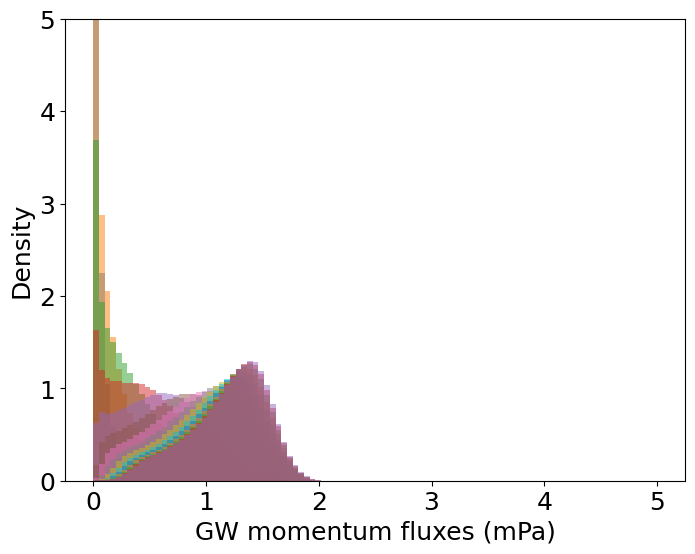

In [47]:
for s in samples_cw_gcm:
    plt.hist(s,bins=np.linspace(0,5,100),density=True,alpha=0.5)
plt.xlabel('GW momentum fluxes (mPa)')
plt.ylabel('Density')
plt.ylim(0,5)


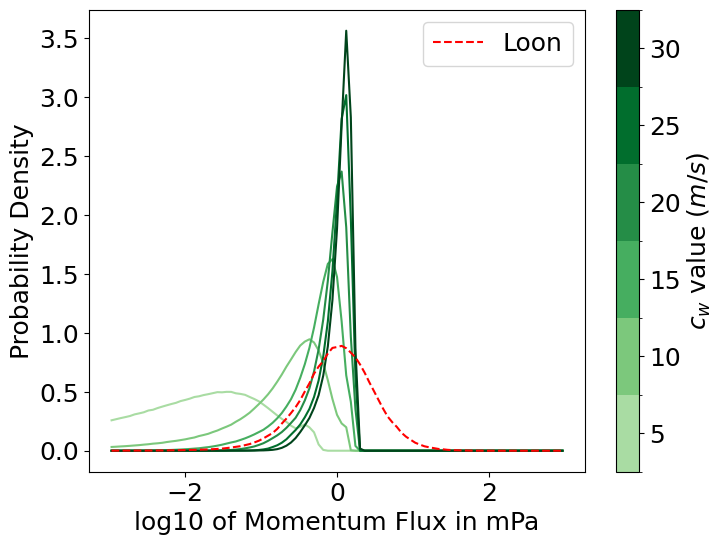

In [49]:
import matplotlib as mpl
logbins_edge = np.linspace(-3,3,100)
logbins_centers = (logbins_edge[:-1] + logbins_edge[1:]) / 2
cmap_base = plt.cm.Greens
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "greens_cut", cmap_base(np.linspace(0.35, 1.0, 256))
)
bounds = np.arange(len(cw_plot)+1) - 0.5   # centers on integers
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
for i,s in enumerate(samples_cw_gcm_plot):
    hist, _ = np.histogram(np.log10(s),bins=logbins_edge,density=True)
    plt.plot(logbins_centers, hist, c=cmap(norm(i)))
log_loon_hist, _ = np.histogram(np.log10(LOON_DATA['u_flux_ptv']),bins=logbins_edge,density=True)
plt.plot(logbins_centers, log_loon_hist, label='Loon', color='red',ls='--')
plt.xlabel('log10 of Momentum Flux in mPa')
plt.ylabel('Probability Density')
plt.legend()
# Colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ticks=range(len(cw)),ax=plt.gca())
cbar.ax.set_yticklabels([f"{val:.0f}" for val in cw])  # label with cw values
cbar.set_label("$c_w$ value ($\\mathit{m/s}$)")
plt.savefig(f'{FIGDIR}/cw_{expcode}.png',dpi=300)

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,8))
ax1.set_title("Norm space mean")
ax1.plot(cw,mean_true_cw,label='GW momentum fluxes')
ax1.set_xlabel('$c_w$ (m/s)')
ax2.set_title("Norm space std")
ax2.plot(cw,std_true_cw,label='GW momentum fluxes')
ax2.set_xlabel('$c_w$ (m/s)')
ax3.set_title("Norm space skew")
ax3.plot(cw,skew_true_cw,label='GW momentum fluxes')
ax3.set_xlabel('$c_w$ (m/s)')

# ax1.legend()
fig.suptitle("AD99 $c_w$ shift")

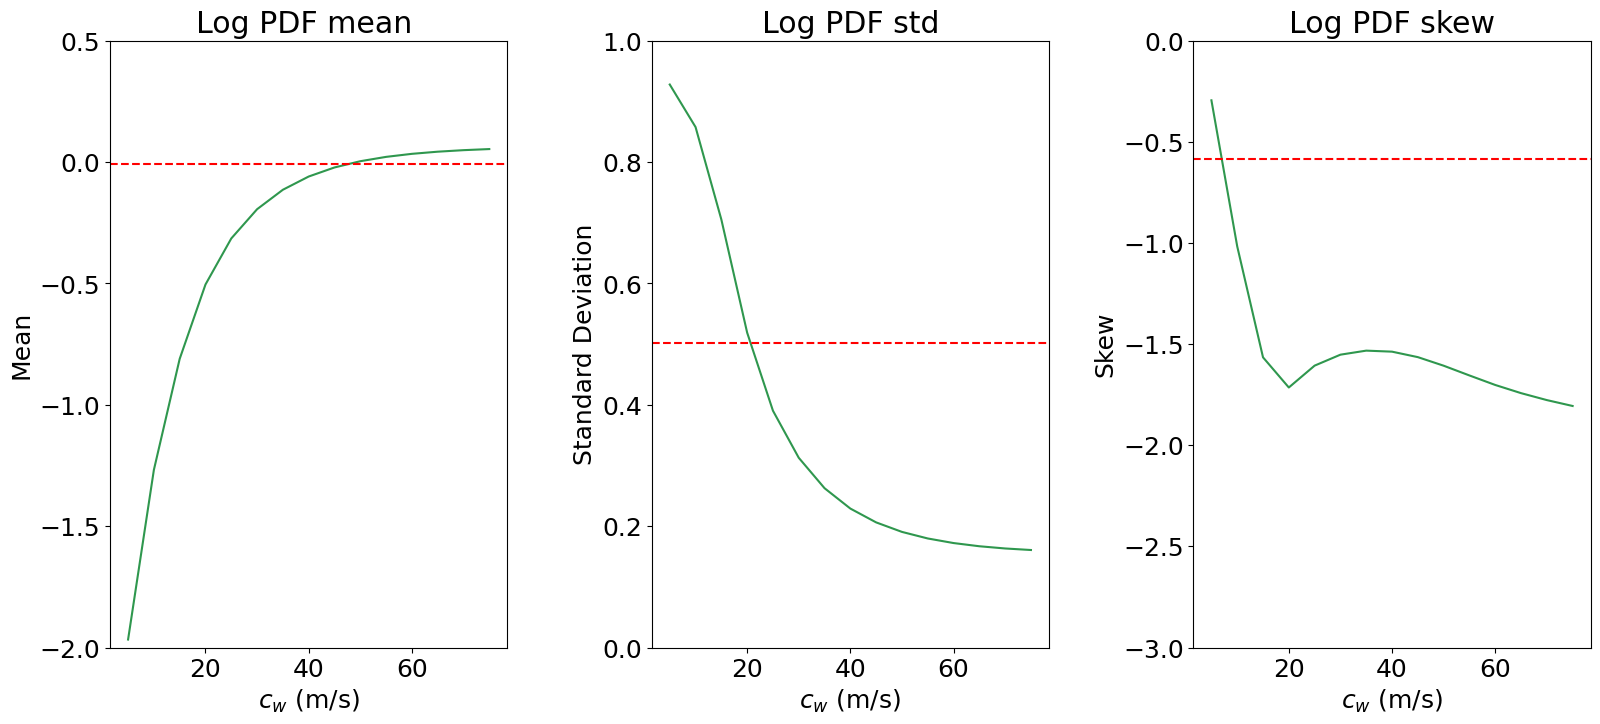

In [50]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(17,8))
fig.tight_layout(pad=3)
ax1.plot(cw,mean_log_cw,label='AD99',c=PLT_GREEN)
ax1.axhline(loon_log_mean,color='red',linestyle='--',label='Loon')
ax1.set_xlabel('$c_w$ (m/s)')
ax1.set_title("Log PDF mean ")
ax1.set_ylabel("Mean")
ax1.set_ylim((-2,0.5))
ax2.plot(cw,std_log_cw,label='AD99',c=PLT_GREEN)
ax2.axhline(loon_log_std,color='red',linestyle='--',label='Loon')
ax2.set_xlabel('$c_w$ (m/s)')
ax2.set_ylim((0,1))
ax2.set_title("Log PDF std")
ax2.set_ylabel("Standard Deviation")

ax3.plot(cw,skew_log_cw,label='AD99',c=PLT_GREEN)
ax3.axhline(loon_log_skew,color='red',linestyle='--',label='Loon')
ax3.set_xlabel('$c_w$ (m/s)')
ax3.set_title("Log PDF skew")
ax3.set_ylabel("Skew")
ax3.set_ylim((-3,0))
# ax1.legend()

fig.savefig(f'{FIGDIR}/{expcode}_cw_logmoments.png',dpi=300)

Text(0.5, 1.0, 'Log space skew')

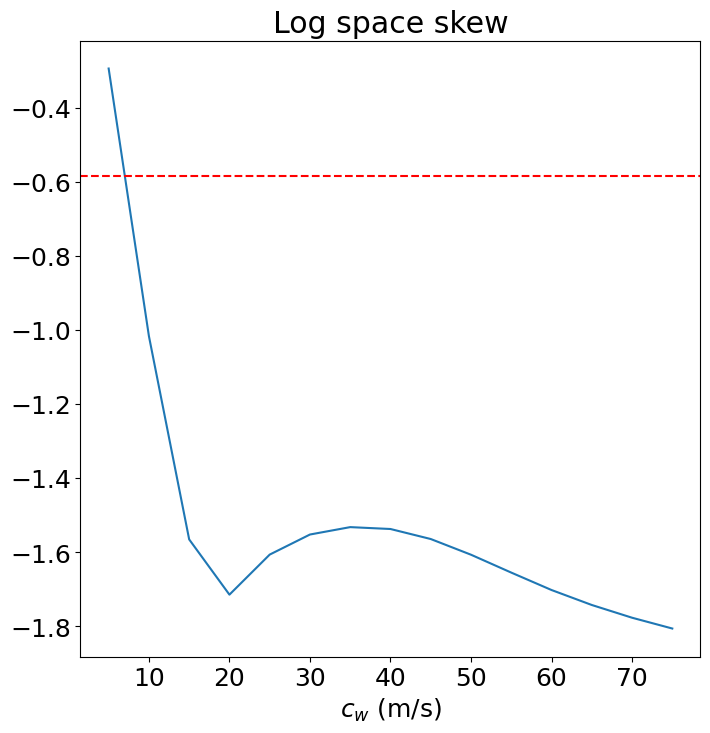

In [51]:
fig,ax3 = plt.subplots(figsize=(8,8))

ax3.plot(cw,skew_log_cw,label='AD99')
ax3.axhline(loon_log_skew,color='red',linestyle='--',label='Loon')
ax3.set_xlabel('$c_w$ (m/s)')

ax3.set_title("Log space skew")